## **Machine Learning 1 - Comparativo entre Random Forest e KNN (K-Nearest Neighbors)**

Para esse estudo comparativo entre modelos de classificação, será utilizado o dataset **penguins**, um dataset de estudo disponibilizado pelo **Seaborn**. Com a seguinte estrutura:

|Coluna|Descrição|Tipo|
|-|-|-|
|species|Fator que denota a espécie do pinguim (Adélie, Chinstrap and Gentoo)|Categórica|
|island|Fator que denota a ilha em que se encontra|Categórica|
|bill_length_mm|Fator que denota o comprimento do bico em milímetros|Numérica|
|bill_depth_mm|Fator que denota a profundidade do bico em milímetros|Numérica|
|flipper_length_mm|Fator que denota o comprimento da nadadeira em milímetros|Numérica|
|body_mass_g|Fator que denota o peso do pinguim em gramas|Numérica|
|sex|Fator que denota o sexo do pinguim|Categórica|
|year|Fator que denota o ano em que a informação foi coletada|Numérica|

O dataset pode ser importado por meio de:
- Do comando pelo Seaborn *load_dataset('penguins')*;
- Baixando o CSV no [Kaggle](https://www.kaggle.com/datasets/larsen0966/penguins).

O objetivo desse projeto é ver se os modelos são capazes de classificar a espécie dos pinguins de forma correta, a fim de avaliar qual dos modelos (Random Forest ou KNN) melhor performa.

### Importação das Bibliotecas

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Análise Inicial dos Dados

In [4]:
penguins = sns.load_dataset('penguins')

In [11]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [16]:
for col in penguins.columns:
  qtd_unique = len(penguins[col].unique())
  perc_nulls = penguins[col].isna().mean()
  print(f"{col}: {qtd_unique} unique values, and {100*perc_nulls:.2f}% of nulls")

species: 3 unique values, and 0.00% of nulls
island: 3 unique values, and 0.00% of nulls
bill_length_mm: 165 unique values, and 0.58% of nulls
bill_depth_mm: 81 unique values, and 0.58% of nulls
flipper_length_mm: 56 unique values, and 0.58% of nulls
body_mass_g: 95 unique values, and 0.58% of nulls
sex: 3 unique values, and 3.20% of nulls


In [7]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Por ser um dataset de estudo, seus dados são bem concisos e apresentam poucos valores nulos, que serão tratados na decorrência do projeto.

### Análise Gráfica dos Dados

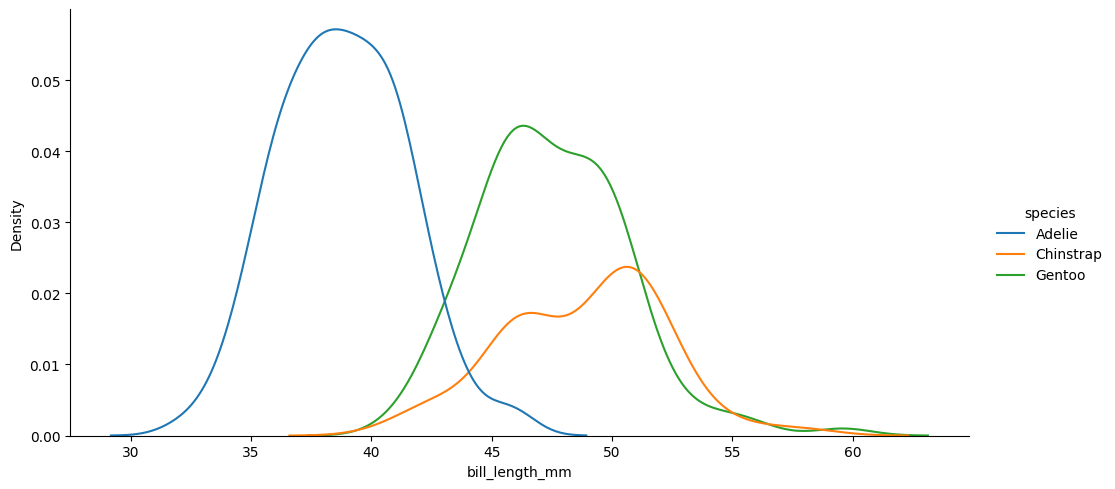

In [18]:
sns.displot(data=penguins, kind='kde', x='bill_length_mm', hue='species', aspect=2)

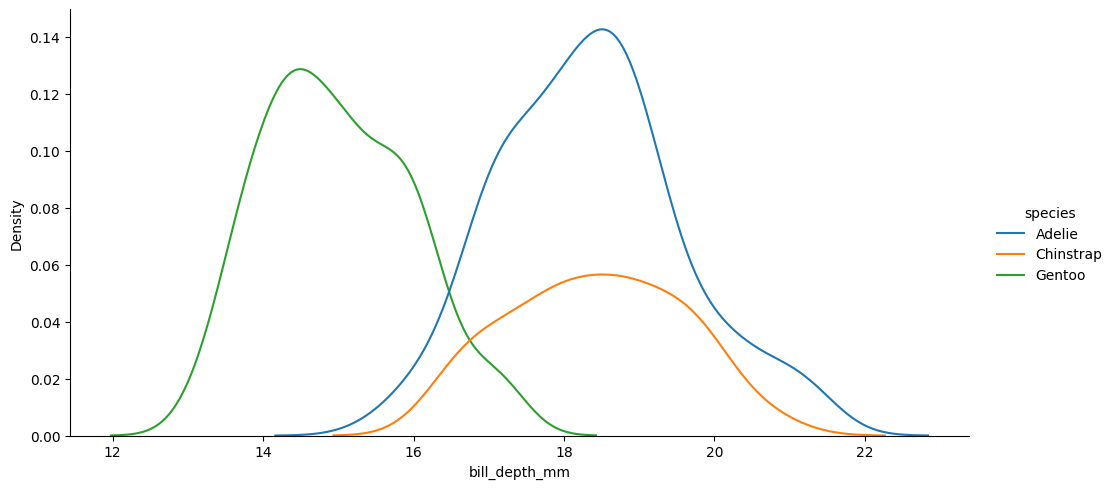

In [19]:
sns.displot(data=penguins, kind='kde', x='bill_depth_mm', hue='species', aspect=2)

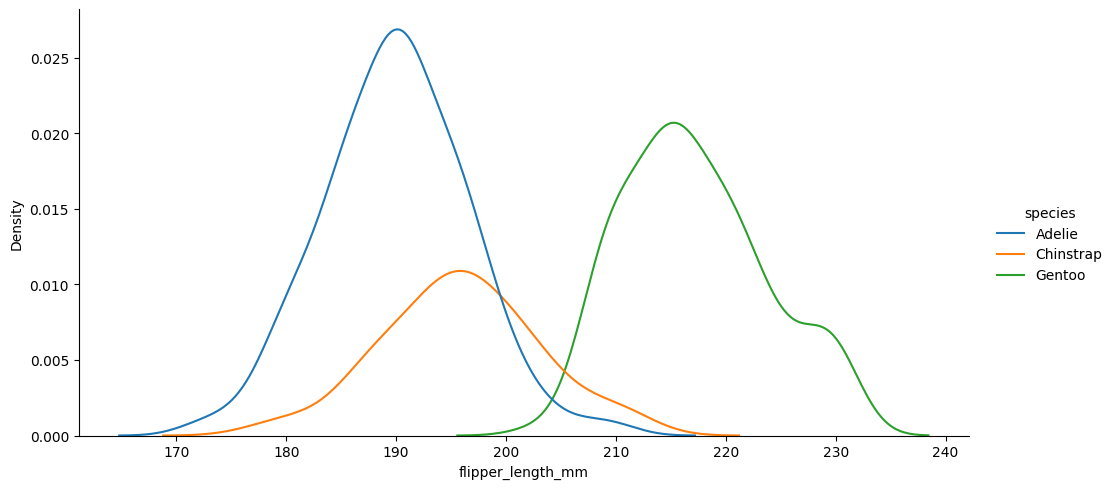

In [20]:
sns.displot(data=penguins, kind='kde', x='flipper_length_mm', hue='species', aspect=2);

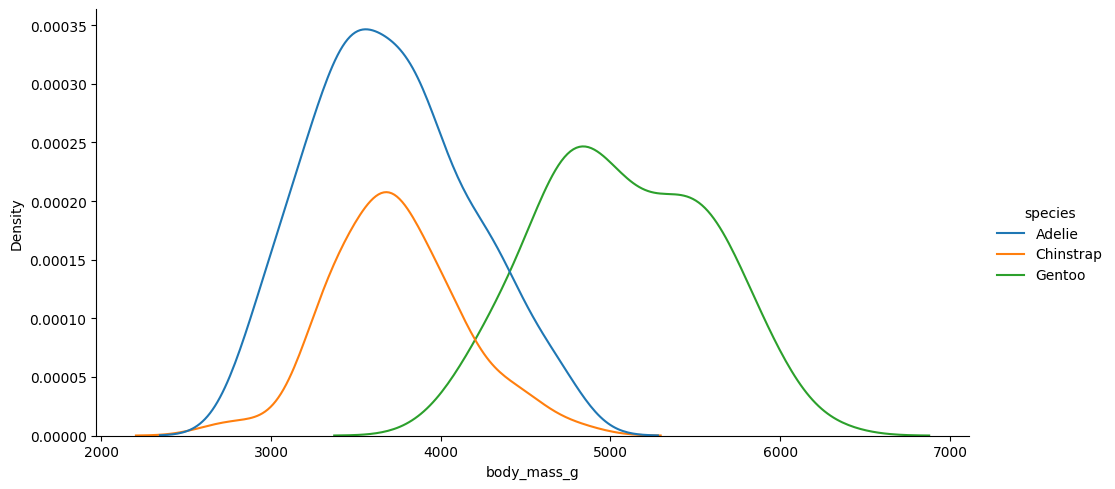

In [21]:
sns.displot(data=penguins, kind='kde', x='body_mass_g', hue='species', aspect=2);

- Adelie e Chinstrap têm massa corporal e profundidade de bico muito semelhantes, enquanto os Gentoo são perceptivelmente mais pesados e têm profundidade média de bico mais baixa. Os Gentoo também tendem a ter as asas mais longas das três espécies.
- Chinstrap e Gentoo são semelhantes em seu comprimento de bico, que geralmente é mais longo do que o dos Adelie.
- Há alguma sobreposição entre os Gentoo e os outros em todas as distribuições, mas a profundidade do bico e o comprimento da asa parecem ter a menor sobreposição.

### Processamento dos Dados

A princípio, precisamos elencar nossas features, e prepará-las para serem utilizadas no modelo.